<a href="https://colab.research.google.com/github/ZheningHuang/personal_website_blogs_code/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16

In [4]:
!git clone https://github.com/bnsreenu/python_for_microscopists.git

Cloning into 'python_for_microscopists'...
remote: Enumerating objects: 894, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 894 (delta 22), reused 1 (delta 0), pack-reused 839
Receiving objects: 100% (894/894), 83.91 MiB | 27.97 MiB/s, done.
Resolving deltas: 100% (293/293), done.
Checking out files: 100% (449/449), done.


In [5]:
print(os.listdir("/content/python_for_microscopists/images/Train_images"))

['Sandstone_Versa0400.tif', 'Sandstone_Versa0050.tif', 'Sandstone_Versa0350.tif', 'Sandstone_Versa0000.tif', 'Sandstone_Versa0200.tif', 'Sandstone_Versa0100.tif', 'Sandstone_Versa0250.tif', 'Sandstone_Versa0300.tif', 'Sandstone_Versa0150.tif']


In [3]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 1024 #Resize images (height  = X, width = Y)
SIZE_Y = 996

In [6]:
#Capture training image info as a list
train_images = []
for directory_path in glob.glob("/content/python_for_microscopists/images/Train_images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [8]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/content/python_for_microscopists/images/Train_masks"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [9]:
X_train = train_images
y_train = train_masks

In [12]:
#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))
#make params non-trainable
for layer in VGG_model.layers:
	layer.trainable = False
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1024, 996, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1024, 996, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1024, 996, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 512, 498, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 512, 498, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 512, 498, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 256, 249, 128)     0     

In [13]:
#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
#to make the training images same dimension as mask images
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1024, 996, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1024, 996, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1024, 996, 64)     36928     
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [14]:
#Now, let us apply feature extractor to our training data
features=new_model.predict(X_train)

In [ ]:
features

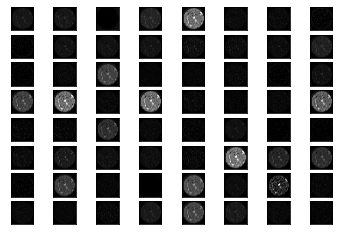

In [16]:
#Plot features to view them
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

In [ ]:
#so far we have all new feature from tranfer learning. Now lets do random forest classification model

In [17]:
#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

#Reshape Y to match X
Y = y_train.reshape(-1)

#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())
##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
dataset = dataset[dataset['Label'] != 0]

#Redefine X and Y for Random Forest
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']

[ 76 150  29 179]
76     4443349
29     4199361
150     368860
179     167566
Name: Label, dtype: int64


In [ ]:

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
model.fit(X_for_RF, Y_for_RF) 

In [ ]:
#Save model for future use
filename = 'RF_model.sav'
pickle.dump(model, open(filename, 'wb'))

#Load model.... 
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/python_for_microscopists/images/Train_images/Sandstone_Versa0000.tif', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

#predict_image = np.expand_dims(X_train[8,:,:,:], axis=0)
X_test_feature = new_model.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

prediction = loaded_model.predict(X_test_feature)

#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('360_segmented.jpg', prediction_image, cmap='gray')
